In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd 
from keras.models import Sequential

: 

In [1]:
mean_data = pd.read_csv(r'C:\Users\Shrinidhi\Desktop\Thesis\fpkm_top_3000_variance_genes.tsv', sep='\t', index_col=0)

# Create the model
model = Sequential()

X = mean_data.drop(columns=['cancer_status']).values

# Convert 'cancer_status' to binary labels 
y = mean_data['cancer_status'].apply(lambda x: 1 if x == 'cancer' else 0).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

NameError: name 'pd' is not defined

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize 
logistic_model = LogisticRegression(max_iter=1000, random_state=42)

# Train
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate 
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))

Accuracy: 0.9864123334204338
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1921
           1       0.98      0.99      0.99      1906

    accuracy                           0.99      3827
   macro avg       0.99      0.99      0.99      3827
weighted avg       0.99      0.99      0.99      3827

Confusion Matrix:
 [[1888   33]
 [  19 1887]]


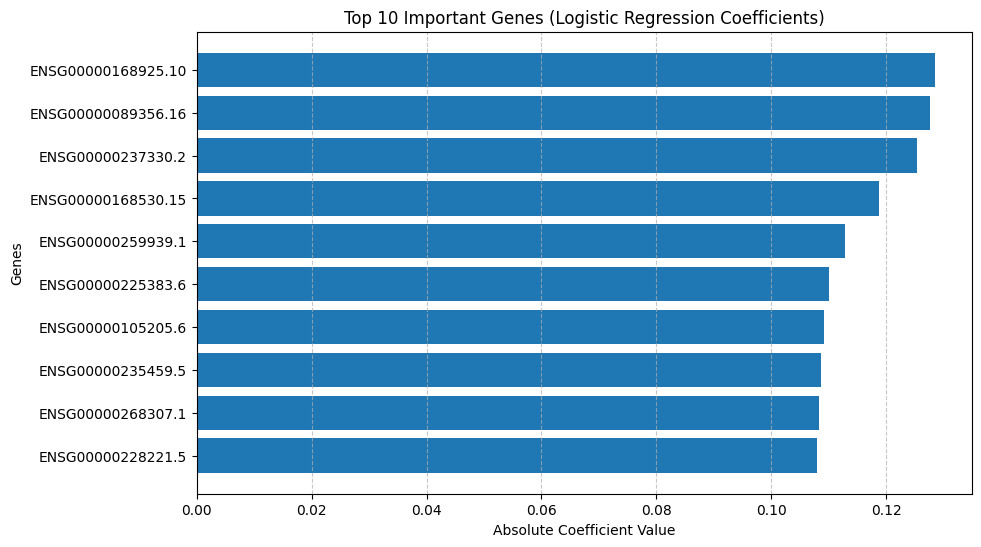

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# absolute coefficients
feature_names = mean_data.drop(columns=['cancer_status']).columns
logreg_importance = np.abs(logistic_model.coef_[0])

# Sort top 100
sorted_indices = np.argsort(logreg_importance)[::-1]
top_100_genes = [feature_names[i] for i in sorted_indices[:100]]

# Save 
top_100_df = pd.DataFrame({
    "Gene": top_100_genes,
    "Importance": logreg_importance[sorted_indices[:100]]
})
top_100_df.to_csv("C://Users//Shrinidhi//Desktop//Thesis//Top 100 genes//LR//top_100_genes_lr_mean.csv", index=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_100_genes[::-1][:10], logreg_importance[sorted_indices[:10]][::-1])
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Genes")
plt.title("Top 10 Important Genes (Logistic Regression Coefficients)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


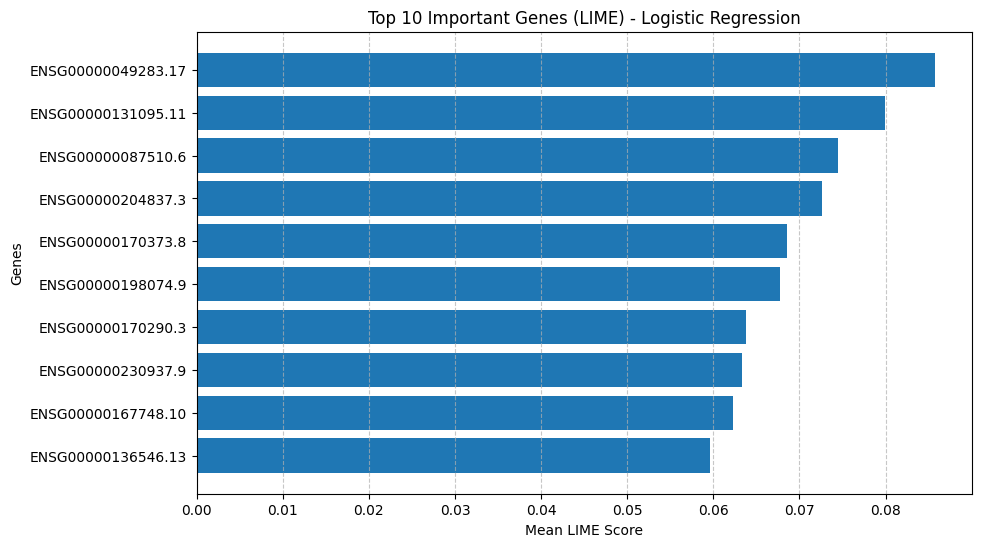

In [ ]:
import lime
import lime.lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature names
feature_names = mean_data.drop(columns=['cancer_status']).columns.tolist()

# LIME 
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train), 
    feature_names=feature_names, 
    class_names=['Normal', 'Cancer'], 
    mode='classification'
)

# Number of samples to analyze
num_samples = 50  
lime_scores = {gene: [] for gene in feature_names}  # Store importance scores

# test samples
for idx in range(num_samples):  
    sample = X_test[idx].reshape(1, -1)  
    explanation = explainer.explain_instance(sample.flatten(), logistic_model.predict_proba, num_features=10)
    
    # feature importance values
    for feature, score in explanation.as_list():
        gene = feature.split()[0]  
        if gene in lime_scores:
            lime_scores[gene].append(score)

# average importance scores
lime_avg_scores = {gene: np.mean(scores) for gene, scores in lime_scores.items() if scores}

# DF
lime_df = pd.DataFrame(list(lime_avg_scores.items()), columns=["Gene", "Mean LIME Score"])
lime_df = lime_df.sort_values(by="Mean LIME Score", ascending=False)

# Save
lime_df.to_csv("C://Users//Shrinidhi//Desktop//Thesis//Top 100 genes//LR//top_100_genes_lime_mean.csv", index=False)

# Plot 
top_10_genes = lime_df.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_genes["Gene"][::-1], top_10_genes["Mean LIME Score"][::-1])
plt.xlabel("Mean LIME Score")
plt.ylabel("Genes")
plt.title("Top 10 Important Genes (LIME) - Logistic Regression")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()


Computing SHAP values for 100 test samples...


  0%|          | 0/100 [00:00<?, ?it/s]

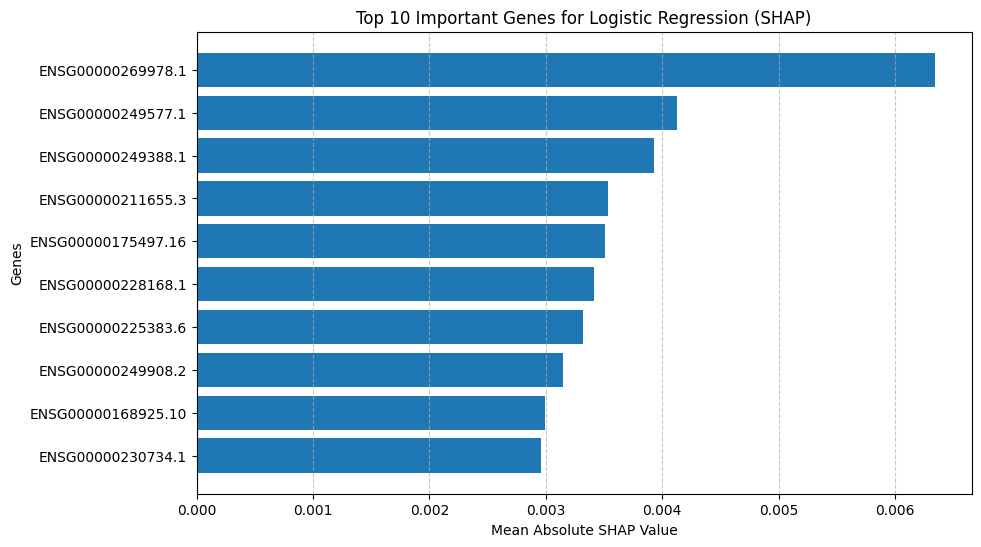

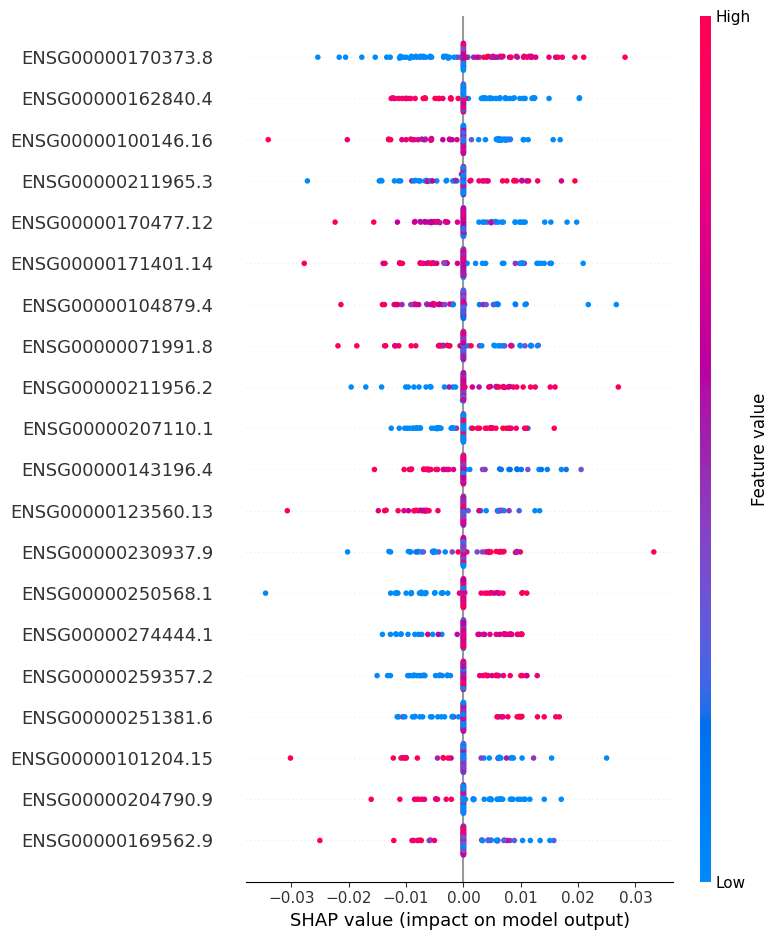

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reduce Background Data 
background = shap.kmeans(X_train, 50)  # k-means to summarize large data
explainer = shap.KernelExplainer(logistic_model.predict_proba, background)  # SHAP 

# Smaller test set
num_test_samples = 100  
X_test_subset = shap.sample(X_test, num_test_samples)

print(f"Computing SHAP values for {num_test_samples} test samples...") 

# Compute 
shap_values = explainer.shap_values(X_test_subset)

# Gene names
feature_names = mean_data.drop(columns=['cancer_status']).columns

# Higher shap is more impact, find most important
mean_abs_shap = np.abs(shap_values[1]).mean(axis=0)  # Looking at class 1 (cancer)

# Sort 
sorted_indices = np.argsort(mean_abs_shap)[::-1]
top_50_genes = [feature_names[i] for i in sorted_indices[:50]]  

# Save
top_50_df = pd.DataFrame({
    "Gene": top_50_genes,
    "Mean Absolute SHAP": mean_abs_shap[sorted_indices[:50]]
})
top_50_df.to_csv("C://Users//Shrinidhi//Desktop//Thesis//Top 50 genes//LR//top_50_genes_shap_mean.csv", index=False)


# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_50_genes[::-1][:10], mean_abs_shap[sorted_indices[:10]][::-1])  # Reverse for readability
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Genes")
plt.title("Top 10 Important Genes for Logistic Regression (SHAP)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

try:
    shap.summary_plot(shap_values[1], X_test_subset, feature_names=feature_names)
except MemoryError:
    print("Skipping SHAP summary plot due to memory limits.")


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(logistic_model, mean_data.drop(columns=['cancer_status']), mean_data['cancer_status'], n_repeats=10, random_state=42)

# Get top 100
sorted_idx = np.argsort(result.importances_mean)[::-1]
top_100_genes_pfi = [feature_names[i] for i in sorted_idx[:100]]

# Save
pd.DataFrame({"Gene": top_100_genes_pfi, "Importance": result.importances_mean[sorted_idx[:100]]}).to_csv(
    "C://Users//Shrinidhi//Desktop//Thesis//Top 100 genes//LR//top_100_genes_lr_pfi_mean.csv", index=False)


X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names